In [1]:
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
import eleanor, os, glob

In [2]:
# tics = np.loadtxt('oelkers_kelt_targets.dat')
# db = pd.read_csv('kelt_zerofa.csv')
db = pd.read_csv('O17_kelt_rotators.csv')

In [25]:
fa = db['False_Alarm_Probability']
tics = db['TIC_ID'].loc[fa>0].values
ps = db['Rotation_Period'].loc[fa>0].values

In [26]:
sectors = []
empty = []

In [27]:
for i, tic in enumerate(tics):
    data = Tesscut.get_sectors(objectname=f"TIC {tic:.0f}")
    if data['sector'].size == 0:
        empty.append(tic)
    else:
        for s in data['sector']:
            sectors.append([tic, s, ps[i]])

In [28]:
sec_ar = np.asarray(sectors)

In [30]:
sec_ar.shape

(64039, 3)

In [31]:
prime_sample = sec_ar[sec_ar[:,1]<27]

In [32]:
prime_sample.shape

(37117, 3)

In [33]:
# export
np.savetxt('empty.dat', empty)
np.savetxt('sectors.dat', sec_ar, delimiter=',')
np.savetxt('prime_sectors.dat', prime_sample, delimiter=',')

In [5]:
# import
empty = np.loadtxt('empty.dat')
sec_ar = np.loadtxt('sectors.dat', delimiter=',')
prime_sample = np.loadtxt('prime_sectors.dat', delimiter=',')

In [34]:
star = eleanor.Source(tic=int(prime_sample[0][0]), sector=int(prime_sample[0][1]), tc=True)

Inflating...


In [35]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=False, do_pca=False, regressors='corner')

In [36]:
from spinneret import *

In [37]:
time = data.time[data.quality==0]
flux = data.corr_flux[data.quality==0]

minfreq = 1/(time[-1] - time[0])

time, flux = nancleaner2d(time, flux)
time, flux = clip(time, flux, 3) #3 sigma clip
flux = lk.LightCurve(time=time, flux=flux).normalize().flux.value - 1

<IPython.core.display.Javascript object>


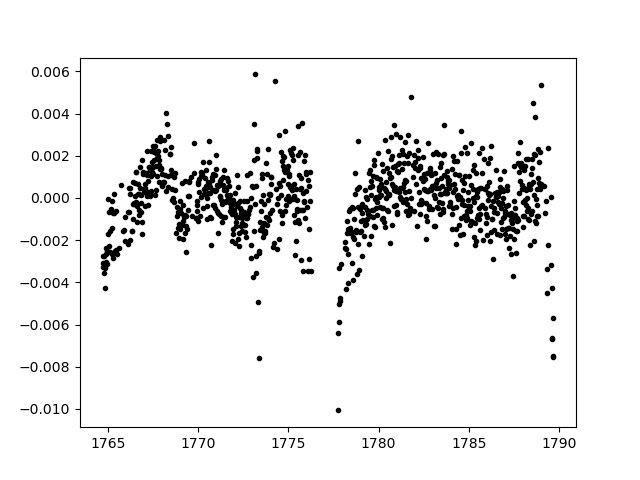

In [39]:
%matplotlib notebook
plt.plot(time, flux, 'k.')

In [40]:
target = Spinner(time, flux)

In [41]:
cadence = 1/24/2

freq, ps = ts.LombScargle(time, flux).autopower(nyquist_factor=1, samples_per_peak=50, minimum_frequency=minfreq)
target.ls_one_term(freq, ps)

freq, ps = ts.LombScargle(time, flux, nterms=2).autopower(nyquist_factor=1, samples_per_peak=50, minimum_frequency=minfreq)
target.ls_two_term(freq, ps)

lags_raw, acf_raw, lags, acf, _x, _y = simple_acf(time, flux, cadence, width=16)
target.acf(lags, acf)

<IPython.core.display.Javascript object>


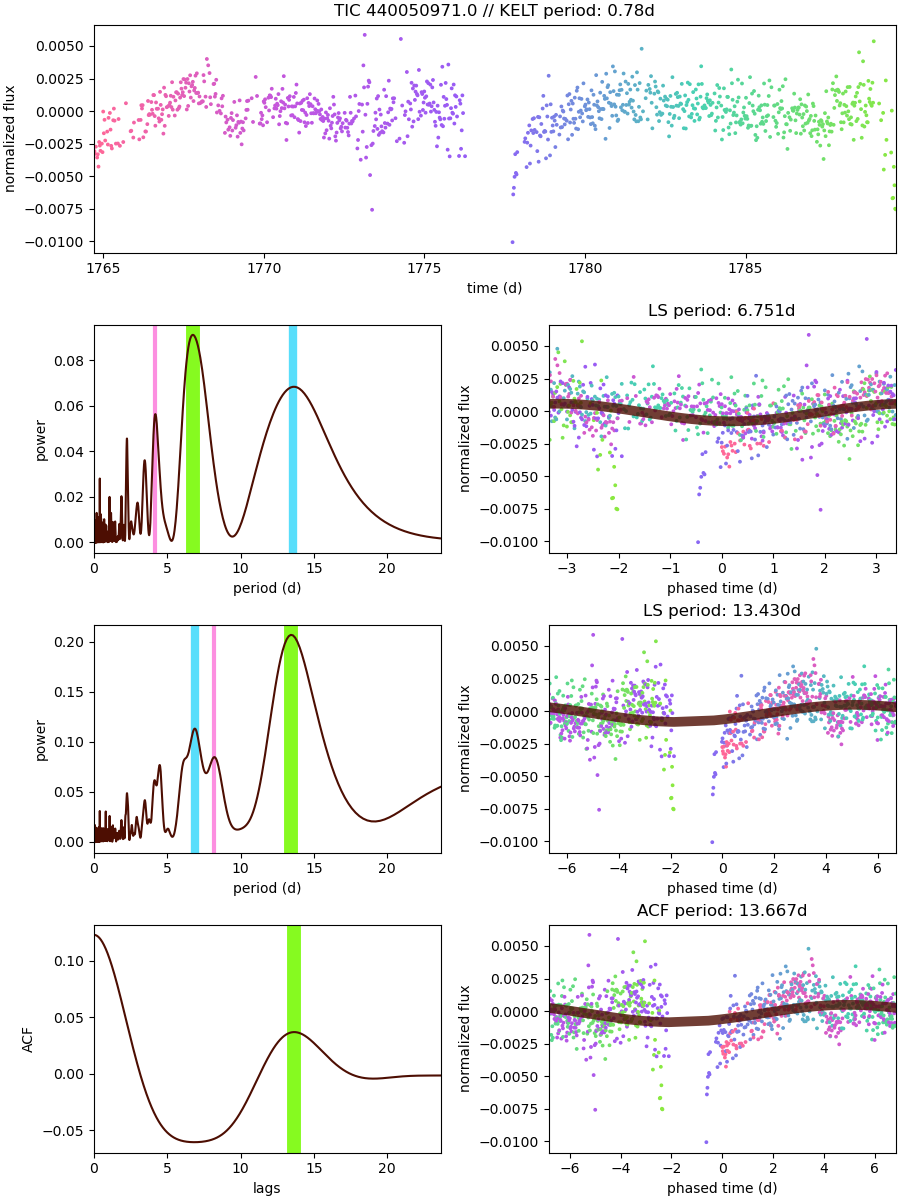

In [42]:
fig1 = target.diagnostic_plot(heading=f'TIC {prime_sample[0][0]} // KELT period: {prime_sample[0][2]:.2f}d')